In [1]:
import numpy as np
import pandas as pd
import scanpy
import anndata as ad

import seaborn as sns; sns.set(color_codes=True); sns.set_style("whitegrid"); 
from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False

import networkx as nx
from scipy.spatial import Delaunay
import copy

In [2]:
adata = scanpy.read_h5ad('/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/data/reannotated_progression_ROIs/adata_e24_10132023.h5ad')
adata

AnnData object with n_obs × n_vars = 1208962 × 46
    obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'ROI', 'ROI_major_category', 'ROI_minor_category', 'phenotype', 'phenotype_v2', 'MELid', 'PCNApos', 'KI67pos', 'MARTpos', 'lineage', 'lineage_grouped', 'lose_08032023', 'proliferation', 'proliferation2', 'prolif2_lineage', 'imageid_raw', 'imageid_modified', 'ROI_epidermis', 'ROI_local_spatial_entropy'
    uns: 'all_markers', 'gates', 'lineage_colors'

In [3]:
def less_first(a, b):
    return [a,b] if a < b else [b,a]

def delaunay2edges(tri):

    list_of_edges = []

    for triangle in tri.simplices:
        for e1, e2 in [[0,1],[1,2],[2,0]]: # for all edges of triangle
            list_of_edges.append(less_first(triangle[e1],triangle[e2])) # always lesser index first

    array_of_edges = np.unique(list_of_edges, axis=0) # remove duplicates

    list_of_lengths = []

    for p1,p2 in array_of_edges:
        x1, y1 = tri.points[p1]
        x2, y2 = tri.points[p2]
        list_of_lengths.append((x1-x2)**2 + (y1-y2)**2)

    array_of_lengths = np.sqrt(np.array(list_of_lengths))

    return array_of_edges, array_of_lengths

In [4]:
def make_graph(df, node_attribute_name='lineage_grouped', plot_graph=False):
    coordinates = np.column_stack((df['X_centroid'], df['Y_centroid']))
    tri = Delaunay(coordinates)

    edges, lengths = delaunay2edges(tri)
    # pruning the graph can be done later - use full graph from Delaunay tri for now
    ''' 
    criterion = np.argwhere(lengths < 30).flatten() # can convert pixels to microns
    selected_edges = edges[criterion]
    print('Removed', len(edges) - len(selected_edges), 'edges')
    '''
    cellids = df['CellID'].reset_index(drop=True)
    
    # map cellids to nodes that connect edges
    for i, (ind1, ind2) in enumerate(edges):
        edges[i] = [cellids[ind1], cellids[ind2]]
    
    # create graph object
    G = nx.Graph()
    G.add_nodes_from(cellids)
    G.add_edges_from(edges) # G.add_edges_from(selected_edges)

    if plot_graph:
        nx.draw(G, with_labels=False, node_size=5, node_color='lightgreen')

    # add weights to graph edges
    for i, e in enumerate(G.edges()):
        G[e[0]][e[1]]['weight'] = lengths[i]

    lineages = df[node_attribute_name]
    lineages.index = df['CellID']
    # add attribute to each node
    nx.set_node_attributes(G, lineages, name=node_attribute_name)
    ### G.nodes[5510]['lineage2'] # example how to access node attribute

    graph_dict = nx.to_dict_of_dicts(G)

    # calculate average num nhbrs across cells
    num_nbhrs = []
    for k, v in graph_dict.items():
        num_nbhrs.append(len(v))
    print(f'Average number of neighbors per cell = {np.mean(num_nbhrs)}')

    return G, graph_dict

In [15]:
def calculate_nbhd_entropy_per_cell_exemplar_regions(adata, node_attribute_name, base=None):
    adata_1 = adata[adata.obs.lineage_grouped != 'SOX10-'] # all tumor cells
    adata_2 = adata_1[adata_1.obs.ROI != 'dysplastic nevus']
    data = adata_2[adata_2.obs.ROI != 'Other']

    full_lineage_list = data.obs[node_attribute_name].unique().tolist()
    print(full_lineage_list)
    exemplar_regions = data.obs.ROI_local_spatial_entropy.unique().to_list()
    exemplar_regions.remove('Other')
    for region in exemplar_regions:
        sample_list = data[data.obs.ROI_local_spatial_entropy == region].obs.imageid.unique()
        for sample in sample_list:
            df = data[data.obs.imageid == sample].obs
            G, graph_dict = make_graph(df, node_attribute_name=node_attribute_name)

            cell_nbhd_dict = dict.fromkeys(df['CellID']) # CellID: [# melanocytic, # transitionary, # undifferentiated]
            for cell_id, nhbrs_dict in graph_dict.items():
                nhbrs_list = list(nhbrs_dict.keys())
                attribute_count_dict = dict.fromkeys(full_lineage_list, 0)
                for cell_nbhr in nhbrs_list:
                    # access node attribute
                    attribute = G.nodes[cell_nbhr][node_attribute_name]
                    attribute_count_dict[attribute] += 1
                cell_nbhd_dict[cell_id] = attribute_count_dict

            cell_nbhd_df = pd.DataFrame.from_dict(cell_nbhd_dict, orient='index')
            cell_nbhd_df = cell_nbhd_df.div(cell_nbhd_df.sum(axis=1), axis=0) # normalize to get probabilities

            base = 2 if base is None else base
            # 0log(0) = 0, skip zero prob values in rows
            cell_nbhd_df['entropy'] = -(cell_nbhd_df * np.log(cell_nbhd_df, out=np.zeros_like(cell_nbhd_df), where=(cell_nbhd_df!=0))/np.log(base)).sum(axis=1)
            cell_nbhd_df['CellID'] = cell_nbhd_df.index
            cell_nbhd_df = cell_nbhd_df.reset_index(drop=True)
            cell_nbhd_df = pd.merge(cell_nbhd_df, df[['CellID', 'X_centroid', 'Y_centroid', 'ROI_local_spatial_entropy']])
            # print(cell_nbhd_df['entropy'].describe())
            cell_nbhd_df = cell_nbhd_df[cell_nbhd_df['ROI_local_spatial_entropy'] == region] # get entropy of region

            # Plot Entropy and Attribute Class Probabilities
            if node_attribute_name == 'lineage_grouped':
                fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
                p1 = ax[0,0].scatter(cell_nbhd_df['X_centroid'],cell_nbhd_df['Y_centroid'],c=cell_nbhd_df['entropy'],s=5,cmap='OrRd', vmin=0, vmax=1.58)
                ax[0,0].set_facecolor('gray')
                ax[0,0].title.set_text('Entropy (Min = 0, Max = 1.58)')
                plt.colorbar(p1, ax=ax[0,0])
                p2 = ax[0,1].scatter(cell_nbhd_df['X_centroid'],cell_nbhd_df['Y_centroid'],c=cell_nbhd_df['melanocytic'],s=5,cmap='viridis', vmin=0, vmax=1)
                ax[0,1].set_facecolor('gray')
                ax[0,1].title.set_text('Melanocytic (Neighbor Prob)')
                plt.colorbar(p2, ax=ax[0,1])
                p3 = ax[1,0].scatter(cell_nbhd_df['X_centroid'],cell_nbhd_df['Y_centroid'],c=cell_nbhd_df['transitionary'],s=5,cmap='viridis', vmin=0, vmax=1)
                ax[1,0].set_facecolor('gray')
                ax[1,0].title.set_text('Transitionary (Neighbor Prob)')
                plt.colorbar(p3, ax=ax[1,0])
                p4 = ax[1,1].scatter(cell_nbhd_df['X_centroid'],cell_nbhd_df['Y_centroid'],c=cell_nbhd_df['undifferentiated'],s=5,cmap='viridis', vmin=0, vmax=1)
                ax[1,1].set_facecolor('gray')
                ax[1,1].title.set_text('Undifferentiated (Neighbor Prob)')
                plt.colorbar(p4, ax=ax[1,1])
                fig.suptitle(f'Sample {sample}, Region {region}', fontsize=15)
                # remove the x and y ticks
                for i in [0,1]:
                    for j in [0,1]:
                        ax[i,j].set_xticks([])
                        ax[i,j].set_yticks([])
                fig.tight_layout()
                plt.savefig(f"/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/figures/grouped-lineage-FOV-ROIs/{sample}_{region}_FOV.pdf", format="pdf", bbox_inches="tight")
            elif node_attribute_name == 'lineage':
                fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
                p1 = ax[0,0].scatter(cell_nbhd_df['X_centroid'],cell_nbhd_df['Y_centroid'],c=cell_nbhd_df['entropy'],s=3,cmap='OrRd', vmin=0, vmax=3)
                ax[0,0].set_facecolor('gray')
                ax[0,0].title.set_text('Entropy (Min = 0, Max = 3)')
                plt.colorbar(p1, ax=ax[0,0])
                
                p2 = ax[0,1].scatter(cell_nbhd_df['X_centroid'],cell_nbhd_df['Y_centroid'],c=cell_nbhd_df['MART1+ MITF+ SOX9+'],s=3,cmap='viridis', vmin=0, vmax=1)
                ax[0,1].set_facecolor('gray')
                ax[0,1].title.set_text('MART1+ MITF+ SOX9+ (Neighbor Prob)')
                plt.colorbar(p2, ax=ax[0,1])

                p3 = ax[0,2].scatter(cell_nbhd_df['X_centroid'],cell_nbhd_df['Y_centroid'],c=cell_nbhd_df['MART1+ MITF+ SOX9-'],s=3,cmap='viridis', vmin=0, vmax=1)
                ax[0,2].set_facecolor('gray')
                ax[0,2].title.set_text('MART1+ MITF+ SOX9- (Neighbor Prob)')
                plt.colorbar(p3, ax=ax[0,2])

                p4 = ax[1,0].scatter(cell_nbhd_df['X_centroid'],cell_nbhd_df['Y_centroid'],c=cell_nbhd_df['MART1+ MITF- SOX9+'],s=3,cmap='viridis', vmin=0, vmax=1)
                ax[1,0].set_facecolor('gray')
                ax[1,0].title.set_text('MART1+ MITF- SOX9+ (Neighbor Prob)')
                plt.colorbar(p4, ax=ax[1,0])

                p5 = ax[1,1].scatter(cell_nbhd_df['X_centroid'],cell_nbhd_df['Y_centroid'],c=cell_nbhd_df['MART1+ MITF- SOX9-'],s=3,cmap='viridis', vmin=0, vmax=1)
                ax[1,1].set_facecolor('gray')
                ax[1,1].title.set_text('MART1+ MITF- SOX9- (Neighbor Prob)')
                plt.colorbar(p5, ax=ax[1,1])

                p6 = ax[1,2].scatter(cell_nbhd_df['X_centroid'],cell_nbhd_df['Y_centroid'],c=cell_nbhd_df['MART1- MITF+ SOX9+'],s=3,cmap='viridis', vmin=0, vmax=1)
                ax[1,2].set_facecolor('gray')
                ax[1,2].title.set_text('MART1- MITF+ SOX9+ (Neighbor Prob)')
                plt.colorbar(p6, ax=ax[1,2])

                p7 = ax[2,0].scatter(cell_nbhd_df['X_centroid'],cell_nbhd_df['Y_centroid'],c=cell_nbhd_df['MART1- MITF+ SOX9-'],s=3,cmap='viridis', vmin=0, vmax=1)
                ax[2,0].set_facecolor('gray')
                ax[2,0].title.set_text('MART1- MITF+ SOX9- (Neighbor Prob)')
                plt.colorbar(p7, ax=ax[2,0])

                p8 = ax[2,1].scatter(cell_nbhd_df['X_centroid'],cell_nbhd_df['Y_centroid'],c=cell_nbhd_df['MART1- MITF- SOX9+'],s=3,cmap='viridis', vmin=0, vmax=1)
                ax[2,1].set_facecolor('gray')
                ax[2,1].title.set_text('MART1- MITF- SOX9+ (Neighbor Prob)')
                plt.colorbar(p8, ax=ax[2,1])

                p9 = ax[2,2].scatter(cell_nbhd_df['X_centroid'],cell_nbhd_df['Y_centroid'],c=cell_nbhd_df['MART1- MITF- SOX9-'],s=3,cmap='viridis', vmin=0, vmax=1)
                ax[2,2].set_facecolor('gray')
                ax[2,2].title.set_text('MART1- MITF- SOX9- (Neighbor Prob)')
                plt.colorbar(p9, ax=ax[2,2])

                fig.suptitle(f'Sample {sample}, Region {region}', fontsize=15)
                # remove the x and y ticks
                for i in [0,1,2]:
                    for j in [0,1,2]:
                        ax[i,j].set_xticks([])
                        ax[i,j].set_yticks([])
                fig.tight_layout()
                plt.savefig(f"/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/figures/lineage-FOV-ROIs/{sample}_{region}_FOV.pdf", format="pdf", bbox_inches="tight")

['transitionary', 'melanocytic', 'undifferentiated']
Average number of neighbors per cell = 5.979152656355077
Average number of neighbors per cell = 5.979152656355077
Average number of neighbors per cell = 5.979152656355077
Average number of neighbors per cell = 5.986525855790241
Average number of neighbors per cell = 5.986525855790241
Average number of neighbors per cell = 5.971761817065684
Average number of neighbors per cell = 5.985171011719684
Average number of neighbors per cell = 5.971761817065684
Average number of neighbors per cell = 5.971956660293181
Average number of neighbors per cell = 5.990846681922196
Average number of neighbors per cell = 5.985171011719684
Average number of neighbors per cell = 5.985171011719684


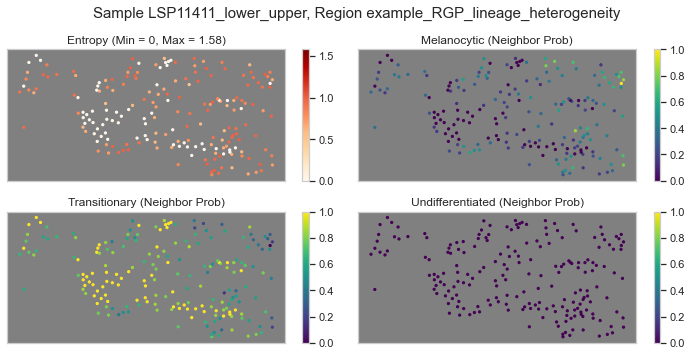

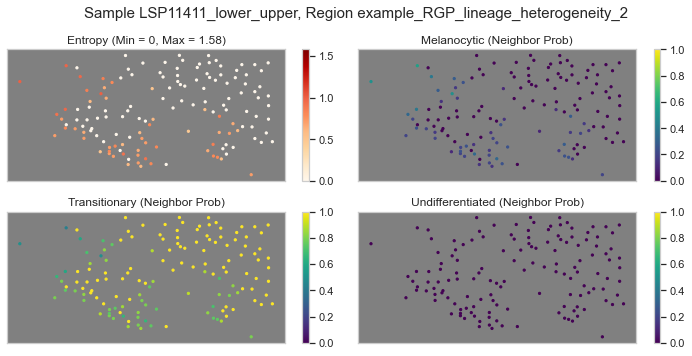

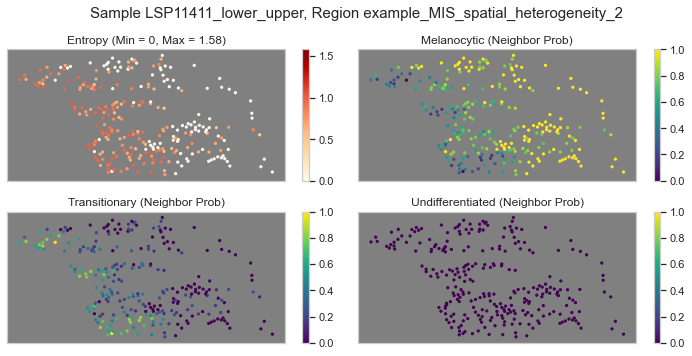

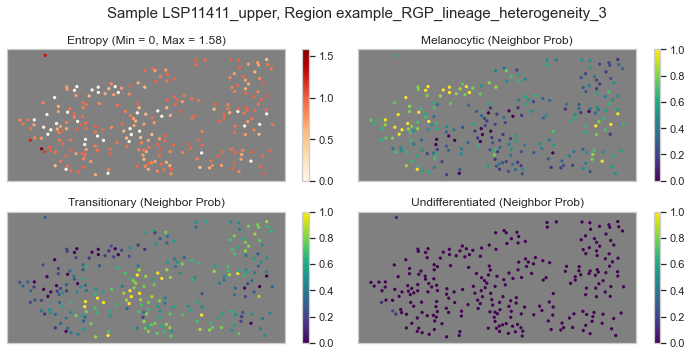

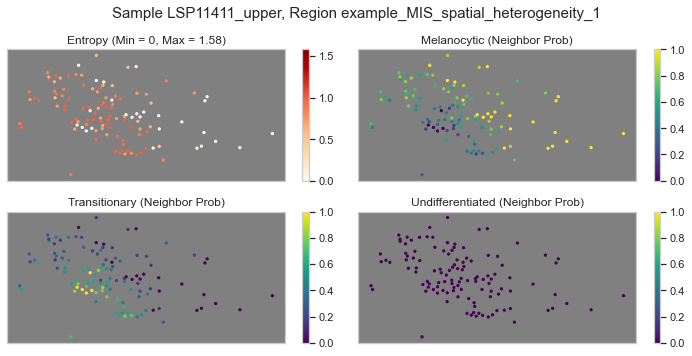

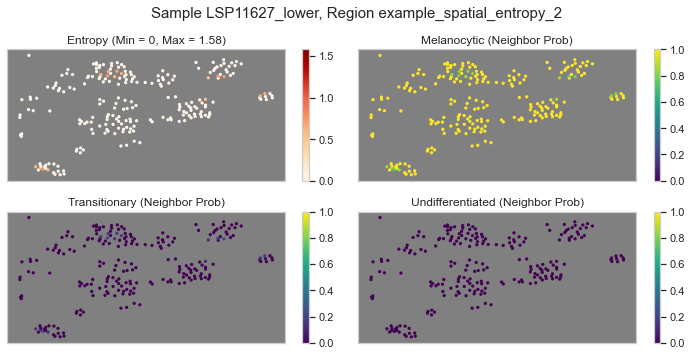

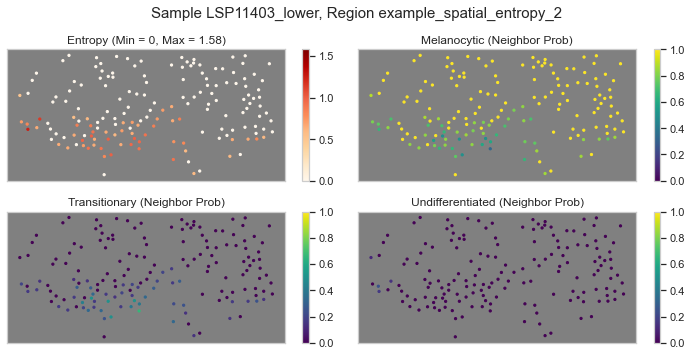

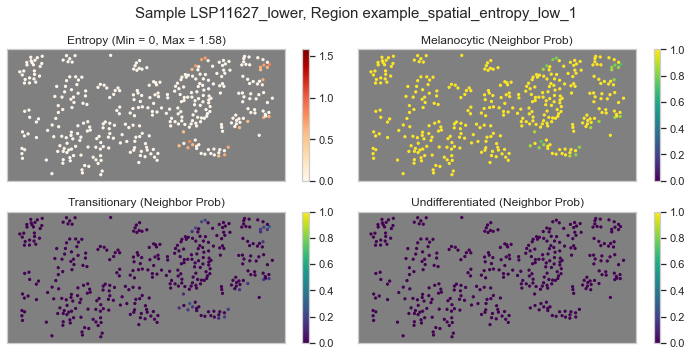

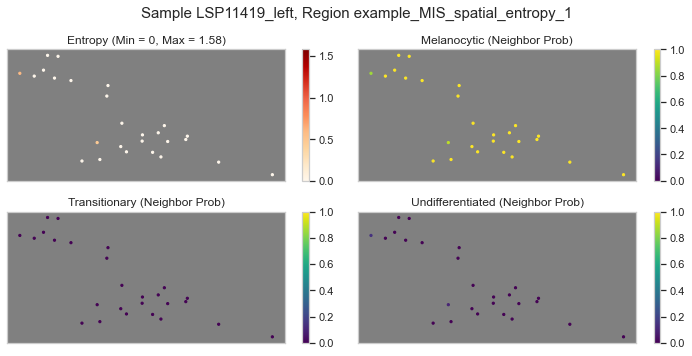

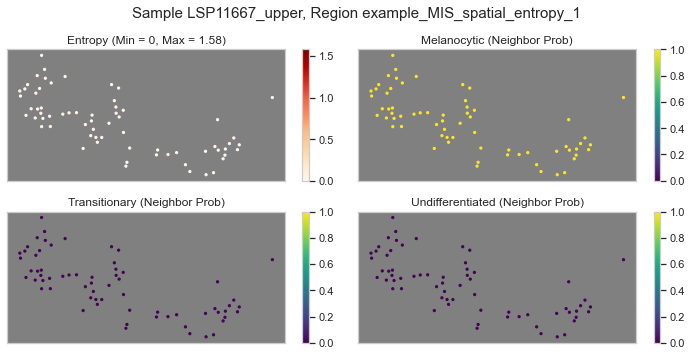

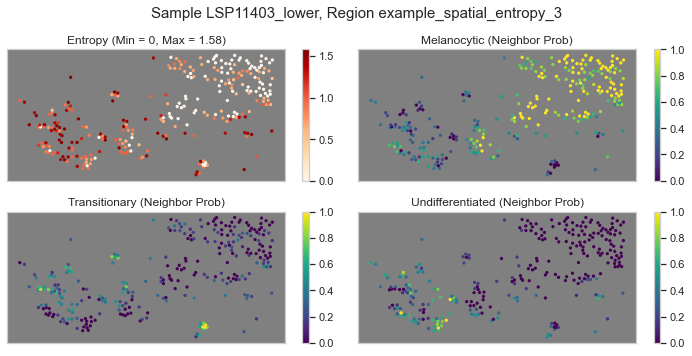

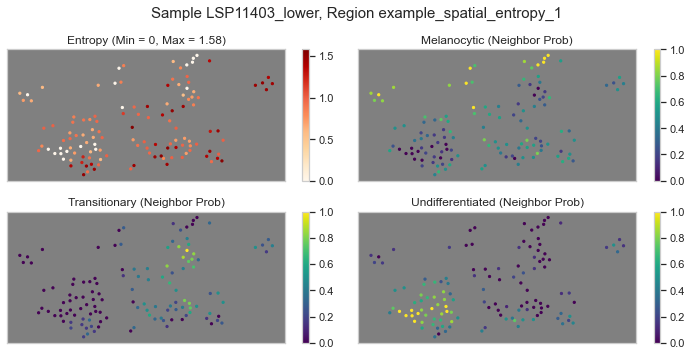

In [16]:
calculate_nbhd_entropy_per_cell_exemplar_regions(adata, node_attribute_name='lineage_grouped', base=None)

In [42]:
# Some samples have more than 1 exemplar region...
exemplar_regions = adata.obs.ROI_local_spatial_entropy.unique().to_list()
for region in exemplar_regions:
    if region != 'Other':
        print(region)
        print('---------')
        df = adata[adata.obs.ROI_local_spatial_entropy == region].obs.imageid.unique()
        print(df)
        print('---------')
        print('\n')

example_RGP_lineage_heterogeneity
---------
['LSP11411_lower_upper']
Categories (1, object): ['LSP11411_lower_upper']
---------


example_RGP_lineage_heterogeneity_2
---------
['LSP11411_lower_upper']
Categories (1, object): ['LSP11411_lower_upper']
---------


example_MIS_spatial_heterogeneity_2
---------
['LSP11411_lower_upper']
Categories (1, object): ['LSP11411_lower_upper']
---------


example_RGP_lineage_heterogeneity_3
---------
['LSP11411_upper']
Categories (1, object): ['LSP11411_upper']
---------


example_MIS_spatial_heterogeneity_1
---------
['LSP11411_upper']
Categories (1, object): ['LSP11411_upper']
---------


example_spatial_entropy_2
---------
['LSP11627_lower', 'LSP11403_lower']
Categories (2, object): ['LSP11627_lower', 'LSP11403_lower']
---------


example_spatial_entropy_low_1
---------
['LSP11627_lower']
Categories (1, object): ['LSP11627_lower']
---------


example_MIS_spatial_entropy_1
---------
['LSP11419_left', 'LSP11667_upper']
Categories (2, object): ['LSP1

### ROIs with non-tumor cells in the background

In [112]:
def calculate_nbhd_entropy_per_cell_exemplar_regions_with_non_tumor_cells(adata, node_attribute_name, base=None):
    adata_1 = adata[adata.obs.lineage_grouped != 'SOX10-'] # all tumor cells
    adata_2 = adata_1[adata_1.obs.ROI != 'dysplastic nevus']
    data = adata_2[adata_2.obs.ROI != 'Other']

    full_lineage_list = data.obs[node_attribute_name].unique().tolist()
    print(full_lineage_list)
    exemplar_regions = data.obs.ROI_local_spatial_entropy.unique().to_list()
    exemplar_regions.remove('Other')
    for region in exemplar_regions:
        sample_list = data[data.obs.ROI_local_spatial_entropy == region].obs.imageid.unique()
        for sample in sample_list:
            df = data[data.obs.imageid == sample].obs
            G, graph_dict = make_graph(df, node_attribute_name=node_attribute_name)

            cell_nbhd_dict = dict.fromkeys(df['CellID']) # CellID: [# melanocytic, # transitionary, # undifferentiated]
            for cell_id, nhbrs_dict in graph_dict.items():
                nhbrs_list = list(nhbrs_dict.keys())
                attribute_count_dict = dict.fromkeys(full_lineage_list, 0)
                for cell_nbhr in nhbrs_list:
                    # access node attribute
                    attribute = G.nodes[cell_nbhr][node_attribute_name]
                    attribute_count_dict[attribute] += 1
                cell_nbhd_dict[cell_id] = attribute_count_dict

            cell_nbhd_df = pd.DataFrame.from_dict(cell_nbhd_dict, orient='index')
            cell_nbhd_df = cell_nbhd_df.div(cell_nbhd_df.sum(axis=1), axis=0) # normalize to get probabilities

            base = 2 if base is None else base
            # 0log(0) = 0, skip zero prob values in rows
            cell_nbhd_df['entropy'] = -(cell_nbhd_df * np.log(cell_nbhd_df, out=np.zeros_like(cell_nbhd_df), where=(cell_nbhd_df!=0))/np.log(base)).sum(axis=1)
            cell_nbhd_df['CellID'] = cell_nbhd_df.index
            cell_nbhd_df = cell_nbhd_df.reset_index(drop=True)

            df2 = adata[adata.obs.imageid == sample].obs
            cell_nbhd_df2 = pd.merge(df2[['CellID', 'X_centroid', 'Y_centroid', 'ROI_local_spatial_entropy']], cell_nbhd_df, how='left', on='CellID')
            # print(cell_nbhd_df['entropy'].describe())
            cell_nbhd_df2 = cell_nbhd_df2[cell_nbhd_df2['ROI_local_spatial_entropy'] == region] # get entropy of region
            cell_nbhd_df3 = cell_nbhd_df2[cell_nbhd_df2.isnull().any(axis=1)]
            #return df2, cell_nbhd_df2, cell_nbhd_df3

            # Plot Entropy and Attribute Class Probabilities
            if node_attribute_name == 'lineage_grouped':
                fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
                p1 = ax[0,0].scatter(cell_nbhd_df2['X_centroid'],cell_nbhd_df2['Y_centroid'],c=cell_nbhd_df2['entropy'],s=7,cmap='OrRd', vmin=0, vmax=1.58)
                p1 = ax[0,0].scatter(cell_nbhd_df3['X_centroid'],cell_nbhd_df3['Y_centroid'],c='silver',s=5)
                ax[0,0].set_facecolor('gainsboro')
                ax[0,0].title.set_text('Entropy (Min = 0, Max = 1.58)')
                #plt.colorbar(p1, ax=ax[0,0])
                p2 = ax[0,1].scatter(cell_nbhd_df2['X_centroid'],cell_nbhd_df2['Y_centroid'],c=cell_nbhd_df2['melanocytic'],s=7,cmap='viridis', vmin=0, vmax=1)
                ax[0,1].set_facecolor('gainsboro')
                ax[0,1].title.set_text('Melanocytic (Neighbor Prob)')
                #plt.colorbar(p2, ax=ax[0,1])
                p3 = ax[1,0].scatter(cell_nbhd_df2['X_centroid'],cell_nbhd_df2['Y_centroid'],c=cell_nbhd_df2['transitionary'],s=7,cmap='viridis', vmin=0, vmax=1)
                ax[1,0].set_facecolor('gainsboro')
                ax[1,0].title.set_text('Transitionary (Neighbor Prob)')
                #plt.colorbar(p3, ax=ax[1,0])
                p4 = ax[1,1].scatter(cell_nbhd_df2['X_centroid'],cell_nbhd_df2['Y_centroid'],c=cell_nbhd_df2['undifferentiated'],s=7,cmap='viridis', vmin=0, vmax=1)
                ax[1,1].set_facecolor('gainsboro')
                ax[1,1].title.set_text('Undifferentiated (Neighbor Prob)')
                #plt.colorbar(p4, ax=ax[1,1])
                fig.suptitle(f'Sample {sample}, Region {region}', fontsize=15)
                # remove the x and y ticks
                for i in [0,1]:
                    for j in [0,1]:
                        ax[i,j].set_xticks([])
                        ax[i,j].set_yticks([])
                fig.tight_layout()
                plt.savefig(f"/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/figures/grouped-lineage-FOV-ROIs-with-non-tumor-cells/{sample}_{region}_FOV.pdf", format="pdf", bbox_inches="tight")

['transitionary', 'melanocytic', 'undifferentiated']
Average number of neighbors per cell = 5.979152656355077
Average number of neighbors per cell = 5.979152656355077
Average number of neighbors per cell = 5.979152656355077
Average number of neighbors per cell = 5.986525855790241
Average number of neighbors per cell = 5.986525855790241
Average number of neighbors per cell = 5.971761817065684
Average number of neighbors per cell = 5.985171011719684
Average number of neighbors per cell = 5.971761817065684
Average number of neighbors per cell = 5.971956660293181
Average number of neighbors per cell = 5.990846681922196
Average number of neighbors per cell = 5.985171011719684
Average number of neighbors per cell = 5.985171011719684


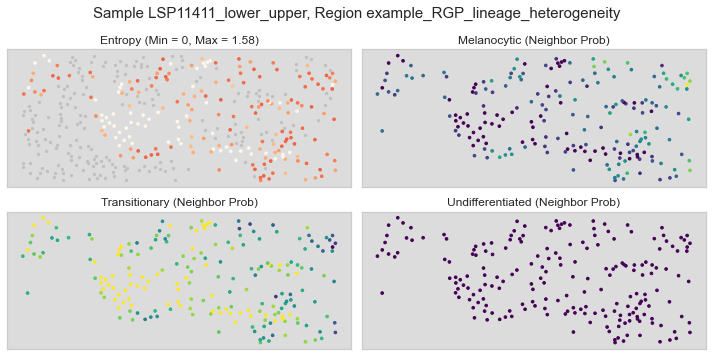

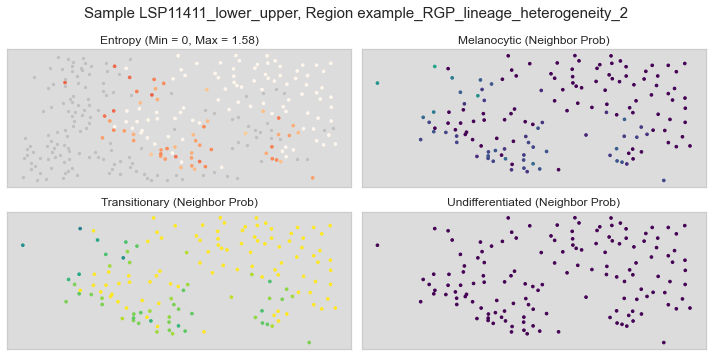

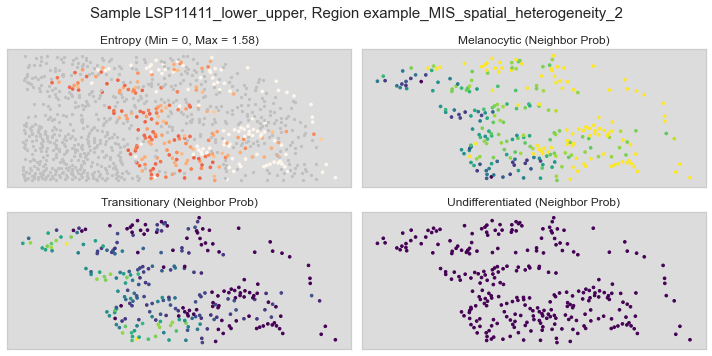

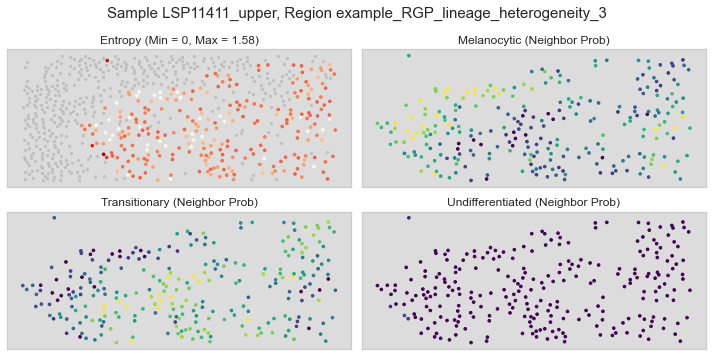

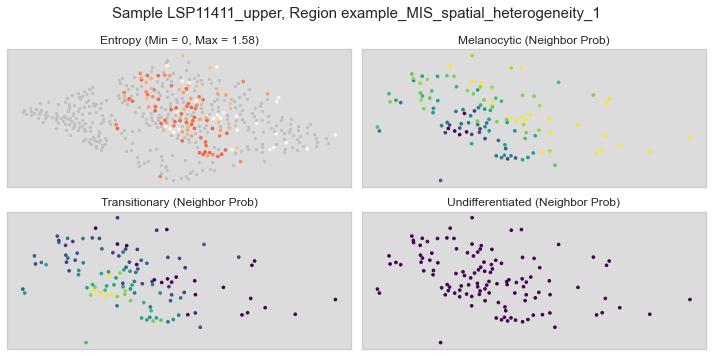

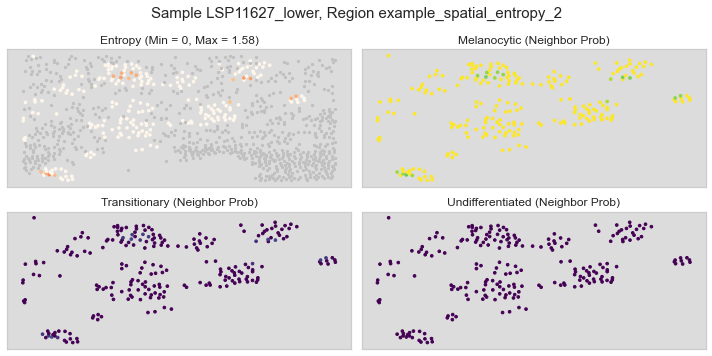

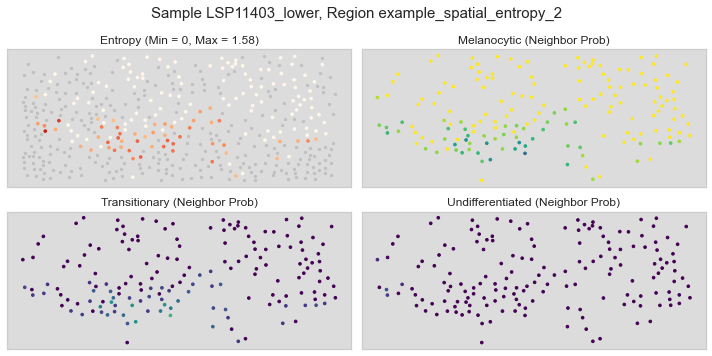

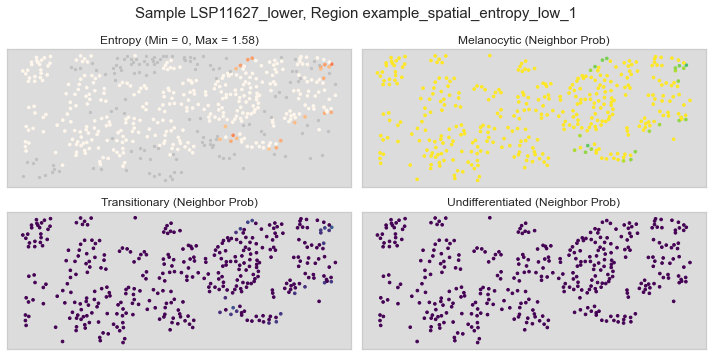

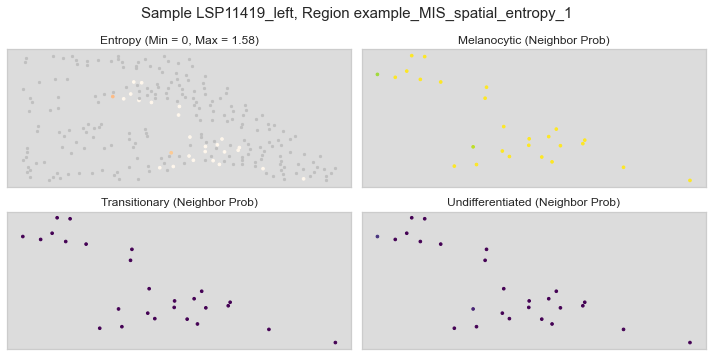

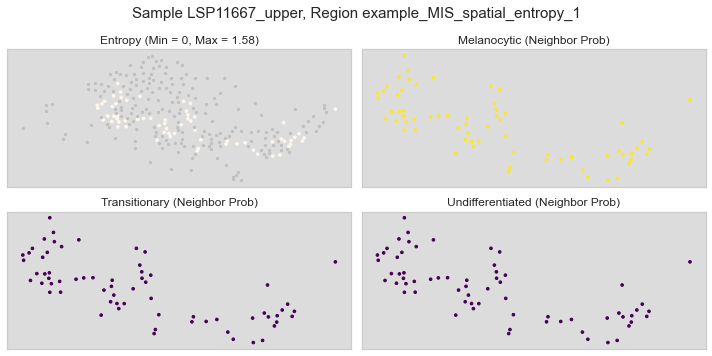

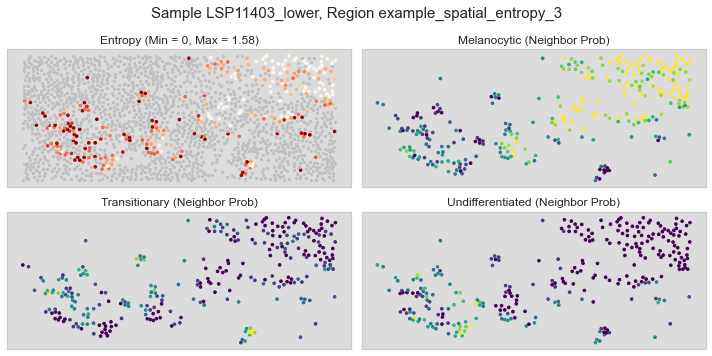

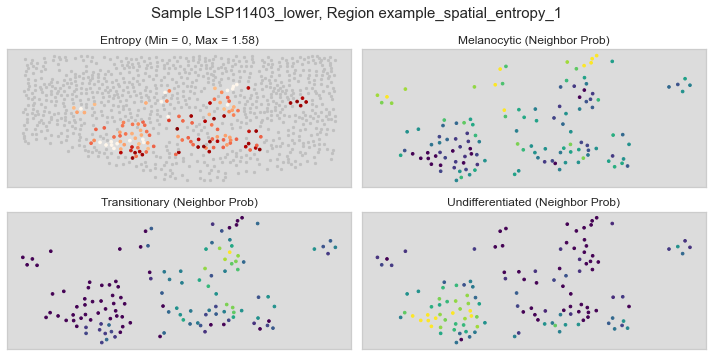

In [113]:
calculate_nbhd_entropy_per_cell_exemplar_regions_with_non_tumor_cells(adata, node_attribute_name='lineage_grouped', base=None)